# Used Packages

In [2]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [3]:
validation_traj = np.load(f'/root/Calibration/R403/npys/all_user_match_data.npy', allow_pickle=True)

In [4]:
parent_path = '/root/Calibration/R403/model'
tim = datetime.now().strftime("%b%d%Y")
path = os.path.join(parent_path, tim+'_Calibrate')
try:
    os.makedirs(path, exist_ok=True)
    print("Directory '%s' created successfully" % path)
except OSError as error:
    print("Directory '%s' can not be created")

Directory '/root/Calibration/R403/model/Jun082024_Calibrate' created successfully


In [5]:
def get_data(validation_traj, num_of_axis, rotation):
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axis == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
                imu[:, 6:9] = imu[:, 6:9] * 180 / np.pi
                mag = data[:, [12, 13, 14]]

                if rotation:
                    imu, mag = process_sequence(imu[:, 6:9], imu[:, 0:3], imu[:, 3:6], mag)
                if num_of_axis == 2:
                    mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
#                 imu = imu[:, [0, 3, 6, 1, 4, 7, 2, 5, 8]]
                pos_mag = np.concatenate((pos, imu, mag, data[:, [15]]), axis=-1)  # 2 + 9 + 3 + 1 = 15
                posture_data[posture_name].append(pos_mag)

    return posture_data

In [6]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(0, len(traj) - length + 1, 5):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

# Data Loader

In [7]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [8]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        split = len(value) * 9 // 10
        tmp1, tmp2 = value[:split], value[split:]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            l = len(traj.values()) - 1
            t_target_data = np.tile(tmp1, (l, 1, 1))
            v_target_data = np.tile(tmp2, (l, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [9]:
def plot_curve(data):
    pos_data = data[:, :2]
    acc_data = data[:, 2:5]
    lin_acc_data = data[:, 5:8]
    gyro_data = data[:, 8:11]
    mag_data = data[:, 11:14]
    X = np.arange(len(data))

    fig, axes = plt.subplots(4, 1, figsize=(10, 6))

    for i in range(4):
        for j in range(3):
            axes[i].plot(X, data[:, 2 + i * 3 + j])
        axes[i].get_xaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

In [10]:
num_of_classes = 1
datapoint_per_second = 20
duration = 2
seq_len = 20

In [23]:
num_of_axis, rotation, gt = 3, False, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'], length=seq_len)
# prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal']], length=seq_len)
# prep_valid_traj['pocket']       = split_traj(posture_data['pocket'], length=seq_len)
# prep_valid_traj['swing']        = split_traj(posture_data['swing'], length=seq_len)
prep_valid_traj['target']       = split_traj(posture_data['target'], length=seq_len)

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)

{1: 'front_pocket', 0: 'target'}


In [27]:
cname = 'front_pocket'

In [28]:
len(train_dataset), len(valid_dataset)

(127, 15)

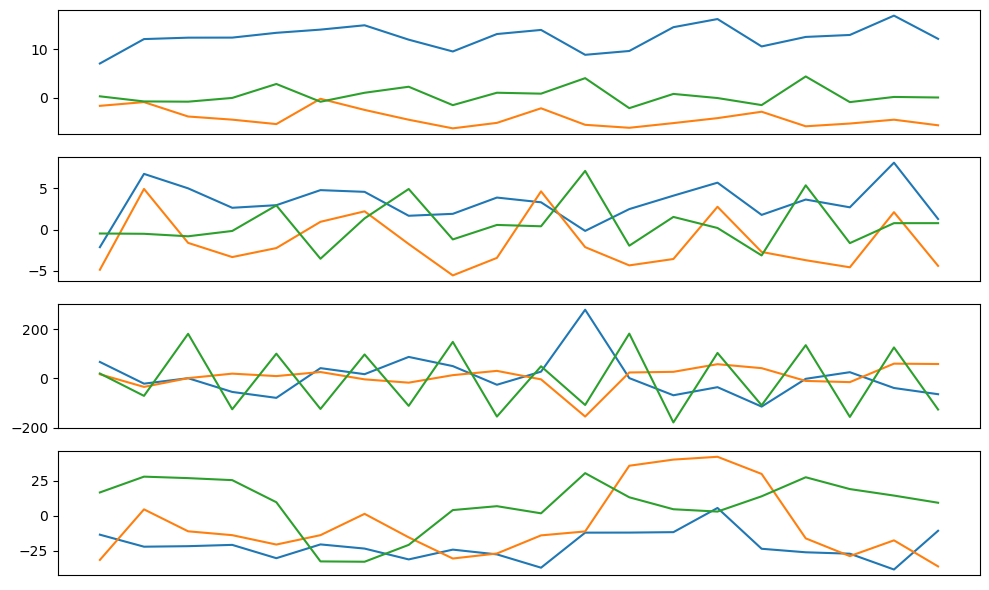

In [15]:
# sdata, slabel, tdata, tlabel = train_dataset[605]
sdata = prep_valid_traj[cname][100]
plot_curve(sdata)

## 分類data

In [16]:
from sklearn import cluster
from dtaidistance import dtw_ndim

In [38]:
def similarity(d1, d2):
    acc_norm = np.linalg.norm(d1[..., :3] - d2[..., :3])
    lin_acc_norm = np.linalg.norm(d1[..., 3:6] - d2[..., 3:6])
    gyro_norm = np.linalg.norm(d1[..., 6:9] - d2[..., 6:9])
    # acc_norm = dtw_ndim.distance_fast(d1[..., :3], d2[..., :3], use_pruning=True)
    # lin_acc_norm = dtw_ndim.distance_fast(d1[..., 3:6], d2[..., 3:6], use_pruning=True)
    # gyro_norm = dtw_ndim.distance_fast(d1[..., 6:9], d2[..., 6:9], use_pruning=True)
    # print(acc_norm, lin_acc_norm, gyro_norm)
    return acc_norm * 1.0 + lin_acc_norm * 1.0 + gyro_norm * 0.1

In [33]:
# data = prep_valid_traj[cname][:, :, 2:14]
data = np.concatenate(posture_data[cname], axis=0)[:, 2:14]

In [39]:
similarity_matrix = np.zeros((len(data), len(data)))

for i in range(len(data)):
    for j in range(len(data)):
        similarity_matrix[i, j] = similarity(data[i], data[j])

In [40]:
np.mean(similarity_matrix)

8.53422221376134

In [45]:
hclust = cluster.DBSCAN(eps=2, min_samples=2, metric='precomputed')
hclust.fit(similarity_matrix)


DBSCAN(eps=2, metric='precomputed', min_samples=2)

In [46]:
hclust.labels_

array([-1,  0,  0,  0,  0,  0,  0, -1,  1,  2,  1, -1,  0, -1,  1, -1, -1,
        0,  0,  3,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  4,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  5, -1,  6,  0,  0,  0,  0,  0,  0,  0,  7,  7,  0,
        0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        4,  0,  0, -1, -1, -1,  0,  8,  0,  0,  4,  0,  0,  5,  9, 10,  0,
        4,  0,  0,  0,  0,  7, -1, -1,  9, 11, -1, 10,  0,  0,  0,  0,  0,
        0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, 12, 10,  0, -1,
       -1,  0, -1, 13, -1, -1, 10, -1, -1, -1, 10, -1, -1, -1,  0,  0, -1,
       -1, -1, -1,  4,  0,  0, -1, 14, -1, -1, -1, -1, -1, -1, -1, 10, -1,
       -1,  0, 15, -1, -1, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 16, 10, -1, 16, 10,  0,
        0,  7, -1,  4, -1, -1, -1,  0, -1, -1, -1,  0,  0, -1, 10,  0,  0,
        0, -1, -1,  0, -1

In [50]:
split = len(prep_valid_traj[cname]) * 9 // 10
split

127

In [51]:
np.where(hclust.labels_[split:] != -1)[0], np.where(hclust.labels_[split:] != -1)[0] + split, hclust.labels_[split:][hclust.labels_[split:] != -1]

(array([ 2,  4,  5,  6,  7, 13, 14]),
 array([129, 131, 132, 133, 134, 140, 141]),
 array([1, 1, 1, 1, 1, 2, 2]))

In [33]:
np.where(hclust.labels_ == 0)

(array([ 0,  6,  7, 11, 14, 15, 75]),)

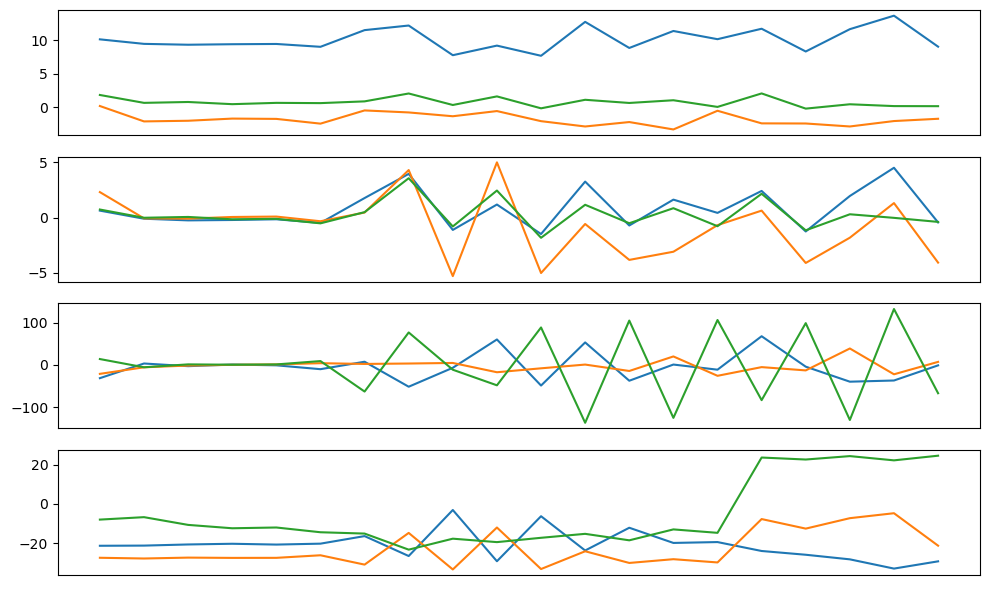

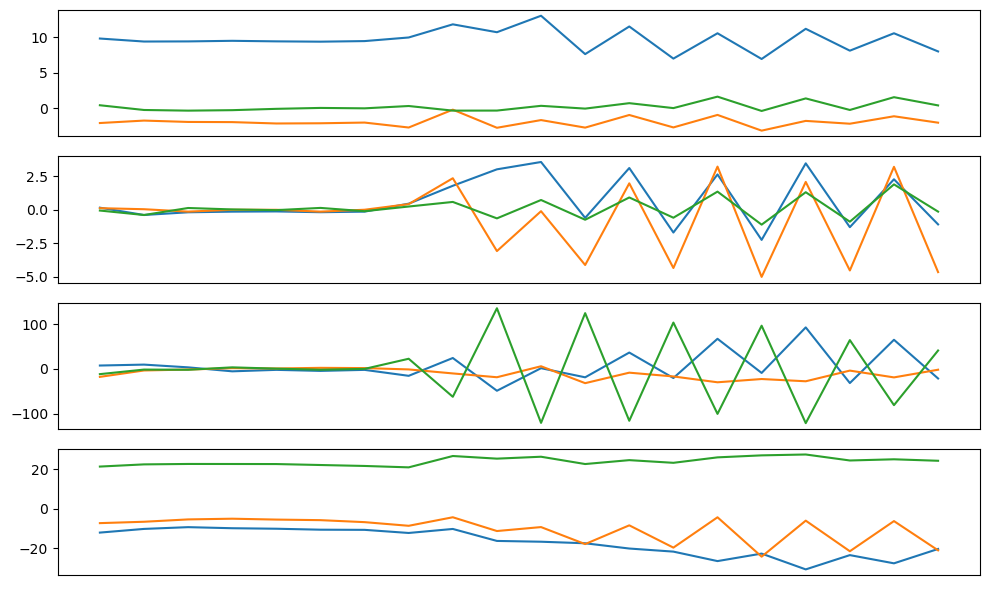

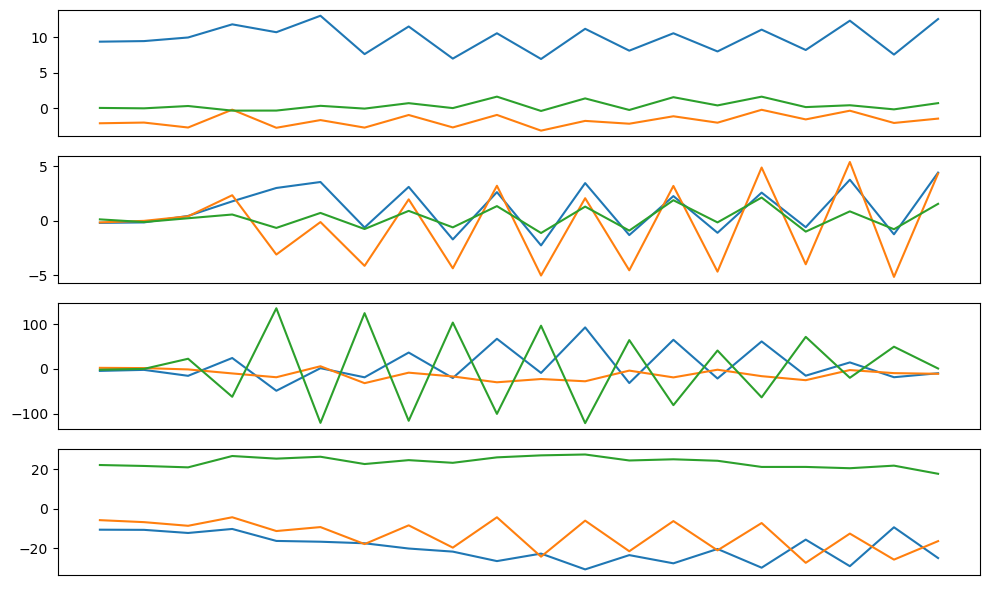

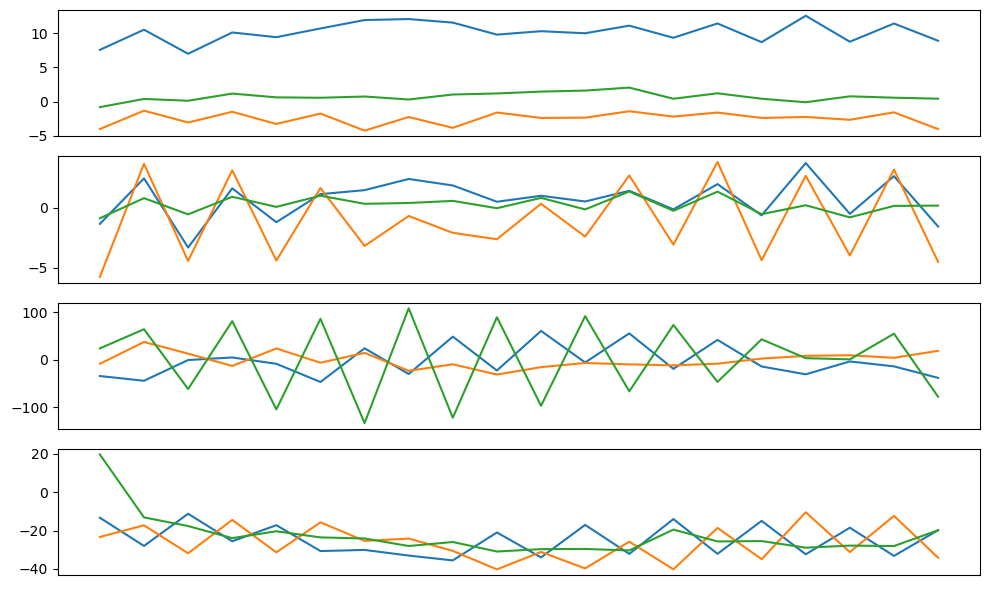

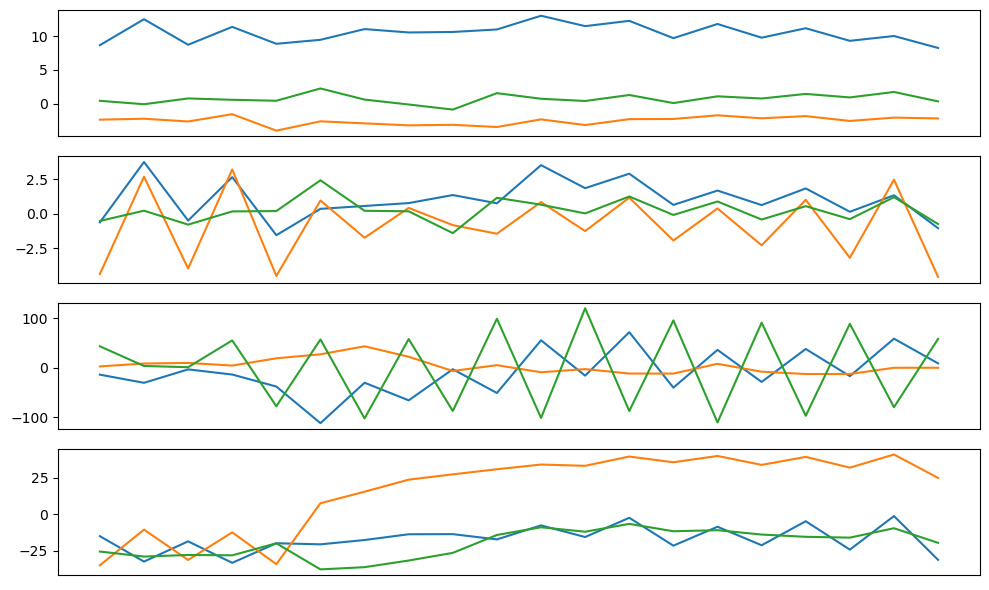

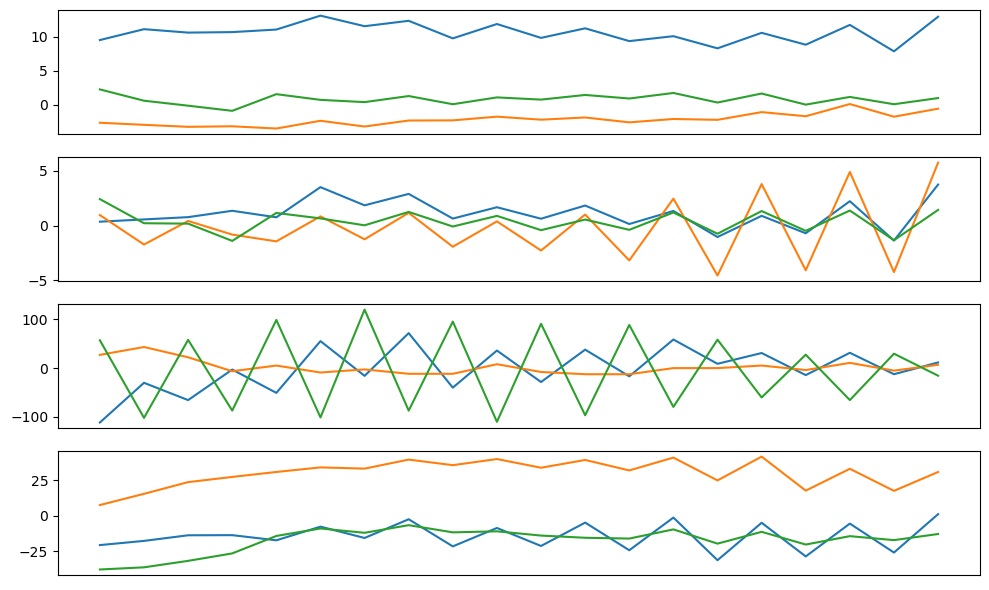

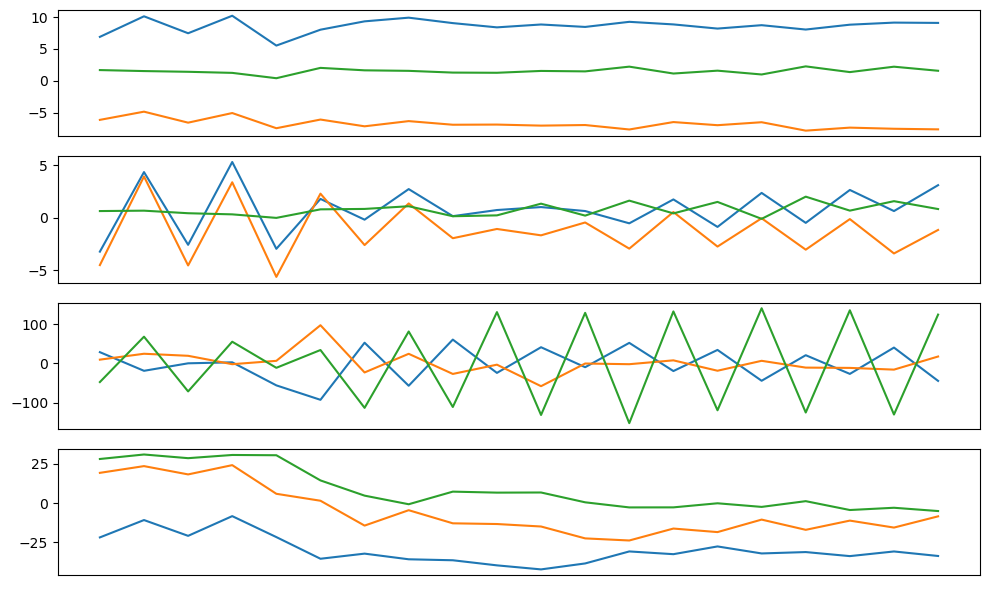

In [34]:
for idx in [ 0,  6,  7, 11, 14, 15, 75]:
    sdata = prep_valid_traj[cname][idx]
    plot_curve(sdata)

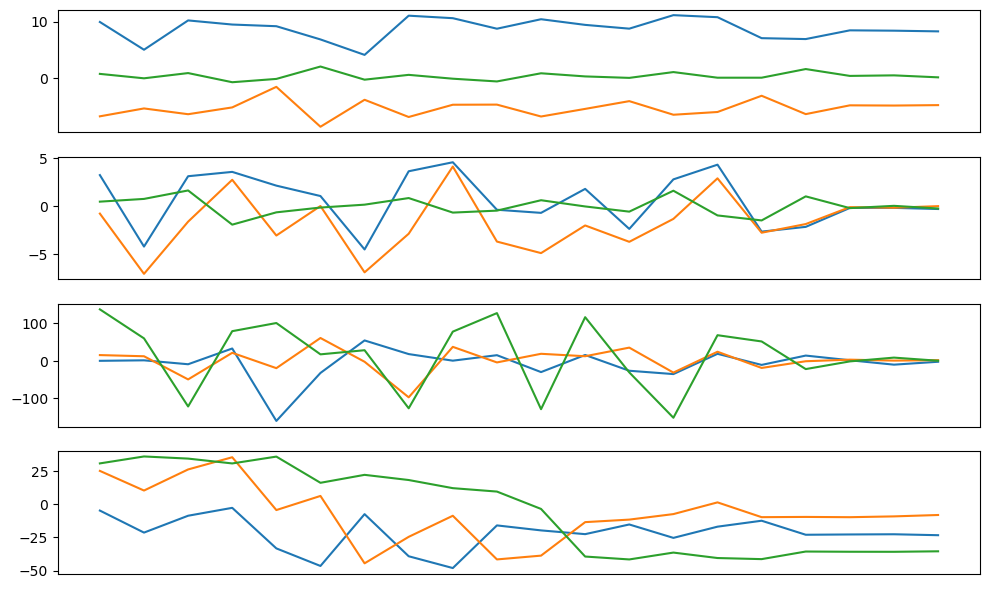

In [54]:
sdata = prep_valid_traj[cname][134]
plot_curve(sdata)